# SFR estimations

This code is intended to estimate the star formation rate of galaxies based on their measured flux at 24 micron, following the recipe presented by Rujopakarn et al. (2013).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

These values are taken from Table 2 in Rujopakarn et al. 2013

In [3]:
z = np.array([0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8])#np.linspace(0,2.8,15)#[0.2*n for n in range(15)]
Az = np.array([2.656,2.35,2.06,2.012,1.659,1.296,1.137,1.039,1.015,0.934,0.922,0.896,0.837,0.768,0.655])
Bz = np.array([0.975,1.02,1.056,1.065,1.094,1.129,1.159,1.179,1.165,1.149,1.145,1.149,1.158,1.175,1.198])
#for i,j,k in zip(z,Az,Bz):
#    print(i,j,k)

Trying two different methods for interpolating the values in Table 2. Both produce very similar values, although they do not reproduce the exact curve for A(z) as shown in Figure 2 of Rujopakarn et al. 2013.

In [4]:
znew = np.linspace(0.0,2.8,50)

Az_intrp = interpolate.interp1d(z, Az, kind='cubic')
Bz_intrp = interpolate.interp1d(z, Bz, kind='cubic')

tckA = interpolate.splrep(z, Az, s=0)
Anew = interpolate.splev(znew, tckA, der=0)
tckB = interpolate.splrep(z, Bz, s=0)
Bnew = interpolate.splev(znew, tckB, der=0)

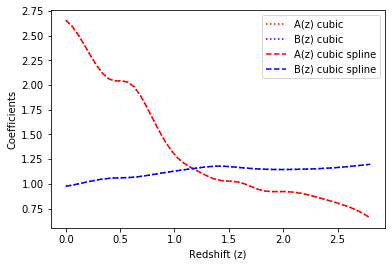

In [5]:
fig, ax = plt.subplots()
#ax.plot(z,Az,'o',color='r')
#ax.plot(z,Bz,'x',color='b')
ax.plot(znew,Az_intrp(znew),':',color='r',label='A(z) cubic')
ax.plot(znew,Bz_intrp(znew),':',color='b',label='B(z) cubic')
ax.plot(znew,Anew,'--',color='r',label='A(z) cubic spline')
ax.plot(znew,Bnew,'--',color='b',label='B(z) cubic spline')
ax.legend(loc='best')
ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Coefficients')
plt.show()

For calculating the luminosity distances, we assume a stadard LambdaCDM cosmology with a Hubble parameter H0 = 70 km/(s*Mpc) and matter density parameter Omega0 = 0.3

In [6]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

The following algorithms are based on the equations presented in Rujopakarn et al. 2013 and adapted from the respective IDL code found at http://ircamera.as.arizona.edu/rujopakarn2013

In [7]:
#def logL24(LTIR):
#    return (np.log10(LTIR)-1.096)/0.982
#
#def SFR(LTIR):
#    if (LTIR>=5*10**9)&(LTIR<=1.3*10**12):
#        return 7.8*10**(logL24(LTIR)-10)
#    elif (LTIR>1.3*10**12):
#        return (7.8*10**(logL24(LTIR)-10))*(6.2*10**(logL24(LTIR)-12))**0.048
def F24_to_LIR(flux, zobj):
    '''Convert Spitzer/MIPS 24 micron flux and redshift to total IR
    luminosity according to Rujopakarn et al. (2013)    
    Input: flux in microJy, redshift
    Output: LIR in Lsun
    '''
    Mpc_to_cm = 3.08568025*(10**24) # 1 Mpc in cm
    microJy_to_Jy = 10**(-6)        # 1 mJy in Jy
    D_L = cosmo.luminosity_distance(zobj).value*Mpc_to_cm # Luminosity distance in cm
    
    logLIR = Az_intrp(zobj) + Bz_intrp(zobj)*(np.log10(flux*microJy_to_Jy*4*np.pi*(D_L**2)) - 45)
    return 10**logLIR

def LIR_to_SFR(LIR):
    '''Convert LIR to SFR
    Input: LIR in Lsun
    Output: SFR in Msun/yr (Kroupa 2002 IMF)
    NOTE: This conversion is calibrated for LIR > 5*10^9, if given a lower value will return an extrapolation
    '''
    L24 = 10**((np.log10(LIR) - 1.096)/0.982)
    
    if (LIR < 1.3*10**12):
        SFR = L24*7.8*10**(-10)
    else:
        SFR = (L24*7.8*10**(-10))*(L24*6.2*10**(-12))**0.048
    return SFR

In [8]:
z_sample = np.linspace(0.1,2.8,50)
#print(z_sample)
LIR_arr = F24_to_LIR(80,z_sample)
#print(LIR_arr)
SFRlimit = [LIR_to_SFR(LIR) for LIR in LIR_arr]
#print(SFRlimit)

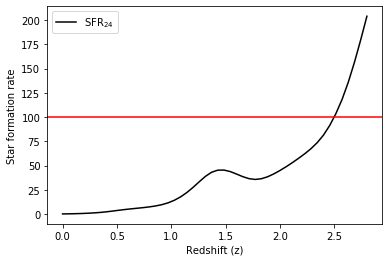

In [9]:
fig, ax = plt.subplots()
ax.plot(znew,SFRlimit,color='k',label='SFR$_{24}$')
ax.legend(loc='best')
ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Star formation rate')
ax.axhline(100,color='r')
plt.show()

In [11]:
LIR_to_SFR(5*10**9)

0.4495277655688017